In [ ]:
from pandas import DataFrame
import torch.nn as nn


from MyModule import (
    load_data, 
    load_vocab, 
    class_weights, 
    train_model_with_validation, 
    test_model_comprehensive, 
    plot_training_curves,
    print_training_summary,
    save_training_results,
    BowDataset
)

train_data = load_data("data/train_tokenized_final.txt", sep=",", is_tokenized=True)
val_data = load_data("data/val_tokenized_final.txt", sep=",", is_tokenized=True)
test_data = load_data("data/test_tokenized_final.txt", sep=",", is_tokenized=True)

# 加载数据
train_dataset = BowDataset(train_data)
val_dataset = BowDataset(val_data)
test_dataset = BowDataset(test_data)

vocab = load_vocab("data/vocab_final.txt")

e:\anaconda3\envs\nlpllma\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import numpy as np
import torch

def load_pretrained_embeddings(embedding_path, vocab, embedding_dim=200):
    """根据已有 vocab 构建嵌入矩阵"""
    embeddings = np.random.normal(scale=0.6, size=(len(vocab), embedding_dim))  # 随机初始化
    with open(embedding_path, 'r', encoding='utf-8', errors='ignore') as f:
        for line in f:
            parts = line.strip().split()
            word = parts[0]
            vector = np.array(parts[1:], dtype='float32')
            if word in vocab.token_to_idx:
                embeddings[vocab[word]] = vector
    return torch.tensor(embeddings, dtype=torch.float32)

embedding_matrix = load_pretrained_embeddings("resources/Word2Vec-100000-small.txt", vocab, embedding_dim=200)

In [3]:
from torch.utils.data import DataLoader
from MyModule import MLP, collate_fn_mlp

# 超参数设置
embedding_dim = 200
num_class = 3
hidden_dim = 256
batch_size = 32
num_epoch = 10


train_data_loader_mlp = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_fn_mlp, shuffle=True)
val_data_loader_mlp = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn_mlp, shuffle=False)
test_data_loader_mlp = DataLoader(test_dataset, batch_size=1, collate_fn=collate_fn_mlp, shuffle=False)

# 加载模型
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mlp_pre_emb = MLP(len(vocab), embedding_dim, hidden_dim, num_class, 
                  embedding_matrix.clone().detach(), freeze=False)
mlp_pre_emb.to(device)

MLP(
  (embeddingbag): EmbeddingBag(35366, 200, mode='mean')
  (linear1): Linear(in_features=200, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=3, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [6]:
# 训练过程
weights = class_weights(train_data)
criterion = nn.CrossEntropyLoss(weight=weights.to(device))
optimizer = torch.optim.Adam(mlp_pre_emb.parameters(), lr=0.001)

mlp_history = train_model_with_validation(
    model=mlp_pre_emb,
    train_loader=train_data_loader_mlp,
    val_loader=val_data_loader_mlp,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epoch,
    device=device
)


Training Epoch 1: 100%|██████████| 8533/8533 [00:35<00:00, 241.39it/s]


Epoch 1/10
    Train Loss: 0.6451	Train Accuracy: 0.7096
    Valid Loss: 0.5937	Valid Accuracy: 0.7362
    Valid Precision: 0.7373	Valid Recall: 0.7362	Valid F1: 0.7287
    ✓ New best validation loss: 0.5937
--------------------------------------------------------------------------------


Training Epoch 2: 100%|██████████| 8533/8533 [00:34<00:00, 243.98it/s]


Epoch 2/10
    Train Loss: 0.5441	Train Accuracy: 0.7636
    Valid Loss: 0.5871	Valid Accuracy: 0.7453
    Valid Precision: 0.7453	Valid Recall: 0.7453	Valid F1: 0.7416
    ✓ New best validation loss: 0.5871
--------------------------------------------------------------------------------


Training Epoch 3: 100%|██████████| 8533/8533 [00:34<00:00, 246.82it/s]


Epoch 3/10
    Train Loss: 0.4947	Train Accuracy: 0.7864
    Valid Loss: 0.5958	Valid Accuracy: 0.7475
    Valid Precision: 0.7466	Valid Recall: 0.7475	Valid F1: 0.7428
    No improvement. Patience: 1/3
--------------------------------------------------------------------------------


Training Epoch 4: 100%|██████████| 8533/8533 [00:34<00:00, 247.96it/s]


Epoch 4/10
    Train Loss: 0.4560	Train Accuracy: 0.8057
    Valid Loss: 0.6124	Valid Accuracy: 0.7447
    Valid Precision: 0.7462	Valid Recall: 0.7447	Valid F1: 0.7433
    No improvement. Patience: 2/3
--------------------------------------------------------------------------------


Training Epoch 5: 100%|██████████| 8533/8533 [00:34<00:00, 246.39it/s]


Epoch 5/10
    Train Loss: 0.4230	Train Accuracy: 0.8215
    Valid Loss: 0.6241	Valid Accuracy: 0.7457
    Valid Precision: 0.7447	Valid Recall: 0.7457	Valid F1: 0.7418
    No improvement. Patience: 3/3
    Early stopping triggered! Best validation loss: 0.5871


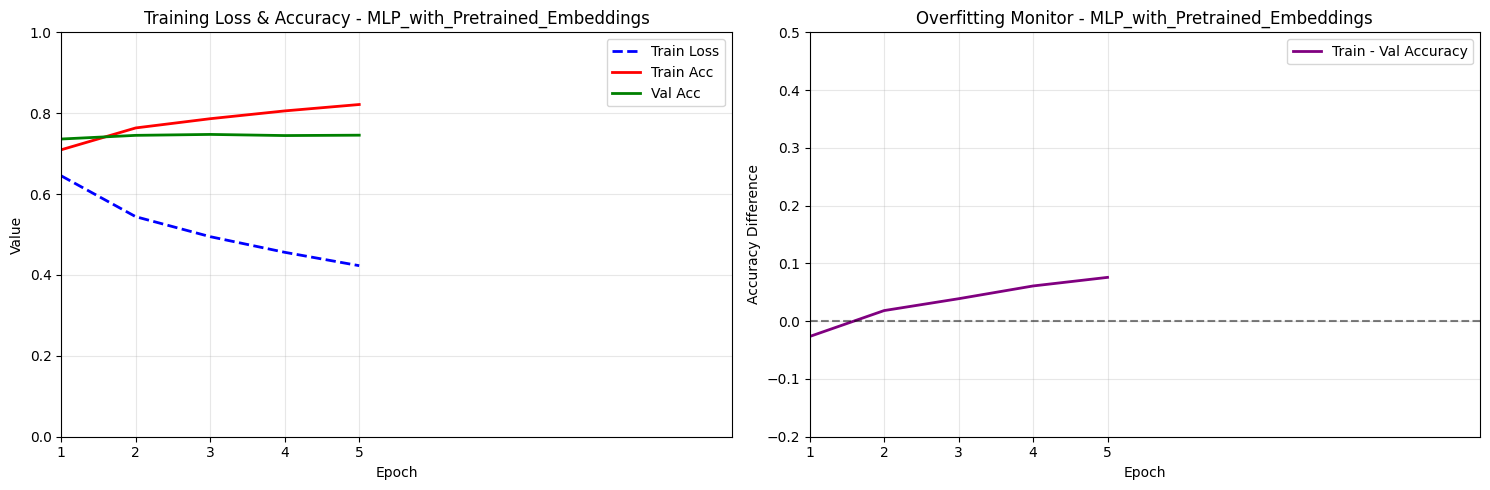


TRAINING SUMMARY
Model Name: MLP_with_Pretrained_Embeddings
Final Train Loss: 0.4230
Final Train Accuracy: 0.8215
Final Val Loss: 0.6241
Final Val Accuracy: 0.7457
Best Val Accuracy: 0.7475 (Epoch 3)
Final Overfitting Gap: 0.0758


In [7]:
# 绘制训练曲线
plot_training_curves("MLP_with_Pretrained_Embeddings", mlp_history)

# 打印训练摘要
print_training_summary("MLP_with_Pretrained_Embeddings", mlp_history)

Testing: 100%|██████████| 58491/58491 [00:44<00:00, 1310.29it/s]



TEST RESULTS
Model Name: MLP_with_pretrained_embeddings
Test Accuracy: 0.7460
Test Precision (weighted): 0.7453
Test Recall (weighted): 0.7460
Test F1 Score (weighted): 0.7421

Detailed Test Classification Report:
              precision    recall  f1-score   support

    Negative     0.7971    0.7341    0.7643     18596
     Neutral     0.6903    0.5741    0.6269     14754
    Positive     0.7393    0.8556    0.7932     25141

    accuracy                         0.7460     58491
   macro avg     0.7422    0.7213    0.7281     58491
weighted avg     0.7453    0.7460    0.7421     58491



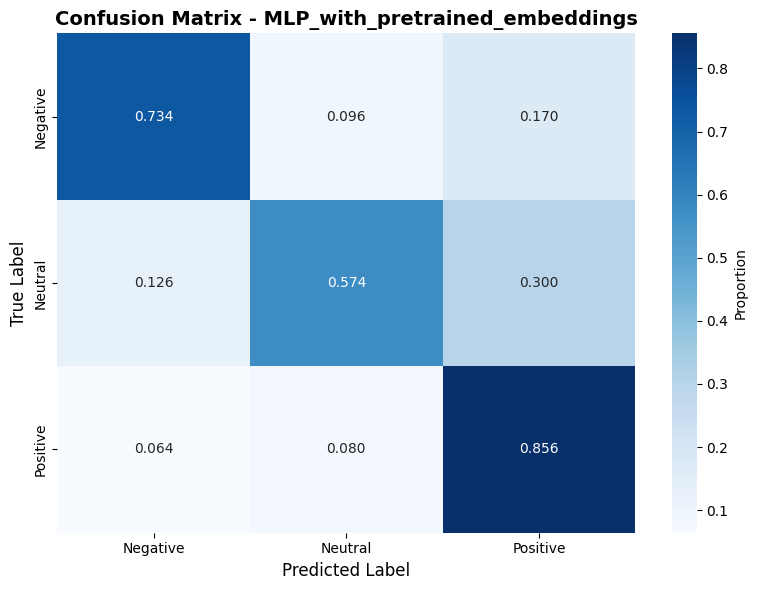


Per-Class Metrics:
------------------------------------------------------------
Negative: Precision=0.7971, Recall=0.7341, F1=0.7643, Support=18596
 Neutral: Precision=0.6903, Recall=0.5741, F1=0.6269, Support=14754
Positive: Precision=0.7393, Recall=0.8556, F1=0.7932, Support=25141


In [8]:
mlp_test_results = test_model_comprehensive(
    model=mlp_pre_emb,
    model_name="MLP_with_pretrained_embeddings",
    test_loader=test_data_loader_mlp,
    device=device,
    target_names=['Negative', 'Neutral', 'Positive']
)

In [9]:
# 保存MLP训练结果
save_training_results(
    model=mlp_pre_emb,
    model_name="MLP with Pretrained Embeddings",
    set_epochs=num_epoch,
    actual_epochs=len(mlp_history['train_losses']),
    device=device,
    use_pretrained_embeddings=True,
    training_history=mlp_history,
    test_results=mlp_test_results,
    save_path="model_training_results.json"
)

✓ 训练结果已保存到 model_training_results.json
  - 模型: MLP with Pretrained Embeddings (MLP)
  - 实际训练轮数: 5
  - 测试准确率: 0.7460
  - 测试F1分数: 0.7421
  - 记录时间: 2025-11-17 09:49:18
  - 总记录数: 1


In [10]:
from MyModule import CNN, collate_fn_cnn

train_data_loader_cnn = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_fn_cnn, shuffle=True)
val_data_loader_cnn = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn_cnn, shuffle=False)
test_data_loader_cnn = DataLoader(test_dataset, batch_size=1, collate_fn=collate_fn_cnn, shuffle=False)

# CNN 相关参数
filter_size = 3
num_filter = 100

# 加载模型
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cnn_pre_emb = CNN(len(vocab), embedding_dim, filter_size, num_filter, num_class, 
                  embedding_matrix.clone().detach(), freeze=False)
cnn_pre_emb.to(device)

CNN(
  (embedding): Embedding(35366, 200)
  (conv1d): Conv1d(200, 100, kernel_size=(3,), stride=(1,), padding=(1,))
  (dropout): Dropout(p=0.5, inplace=False)
  (linear): Linear(in_features=100, out_features=3, bias=True)
)

In [11]:
# 训练过程
weights = class_weights(train_data)
criterion = nn.CrossEntropyLoss(weight=weights.to(device))
optimizer = torch.optim.Adam(cnn_pre_emb.parameters(), lr=0.001)

cnn_history = train_model_with_validation(
    model=cnn_pre_emb,
    train_loader=train_data_loader_cnn,
    val_loader=val_data_loader_cnn,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epoch,
    device=device
)

Training Epoch 1: 100%|██████████| 8533/8533 [00:38<00:00, 220.76it/s]


Epoch 1/10
    Train Loss: 0.6135	Train Accuracy: 0.7235
    Valid Loss: 0.5978	Valid Accuracy: 0.7432
    Valid Precision: 0.7472	Valid Recall: 0.7432	Valid F1: 0.7339
    ✓ New best validation loss: 0.5978
--------------------------------------------------------------------------------


Training Epoch 2: 100%|██████████| 8533/8533 [00:38<00:00, 220.57it/s]


Epoch 2/10
    Train Loss: 0.5231	Train Accuracy: 0.7727
    Valid Loss: 0.5785	Valid Accuracy: 0.7494
    Valid Precision: 0.7526	Valid Recall: 0.7494	Valid F1: 0.7445
    ✓ New best validation loss: 0.5785
--------------------------------------------------------------------------------


Training Epoch 3: 100%|██████████| 8533/8533 [00:36<00:00, 236.28it/s]


Epoch 3/10
    Train Loss: 0.4755	Train Accuracy: 0.7965
    Valid Loss: 0.5835	Valid Accuracy: 0.7569
    Valid Precision: 0.7571	Valid Recall: 0.7569	Valid F1: 0.7569
    No improvement. Patience: 1/3
--------------------------------------------------------------------------------


Training Epoch 4: 100%|██████████| 8533/8533 [00:35<00:00, 238.76it/s]


Epoch 4/10
    Train Loss: 0.4370	Train Accuracy: 0.8158
    Valid Loss: 0.5766	Valid Accuracy: 0.7447
    Valid Precision: 0.7526	Valid Recall: 0.7447	Valid F1: 0.7437
    ✓ New best validation loss: 0.5766
--------------------------------------------------------------------------------


Training Epoch 5: 100%|██████████| 8533/8533 [00:35<00:00, 239.06it/s]


Epoch 5/10
    Train Loss: 0.4017	Train Accuracy: 0.8329
    Valid Loss: 0.5813	Valid Accuracy: 0.7506
    Valid Precision: 0.7498	Valid Recall: 0.7506	Valid F1: 0.7465
    No improvement. Patience: 1/3
--------------------------------------------------------------------------------


Training Epoch 6: 100%|██████████| 8533/8533 [00:35<00:00, 238.79it/s]


Epoch 6/10
    Train Loss: 0.3714	Train Accuracy: 0.8464
    Valid Loss: 0.5968	Valid Accuracy: 0.7453
    Valid Precision: 0.7454	Valid Recall: 0.7453	Valid F1: 0.7426
    No improvement. Patience: 2/3
--------------------------------------------------------------------------------


Training Epoch 7: 100%|██████████| 8533/8533 [00:35<00:00, 238.12it/s]


Epoch 7/10
    Train Loss: 0.3446	Train Accuracy: 0.8580
    Valid Loss: 0.6323	Valid Accuracy: 0.7445
    Valid Precision: 0.7471	Valid Recall: 0.7445	Valid F1: 0.7456
    No improvement. Patience: 3/3
    Early stopping triggered! Best validation loss: 0.5766


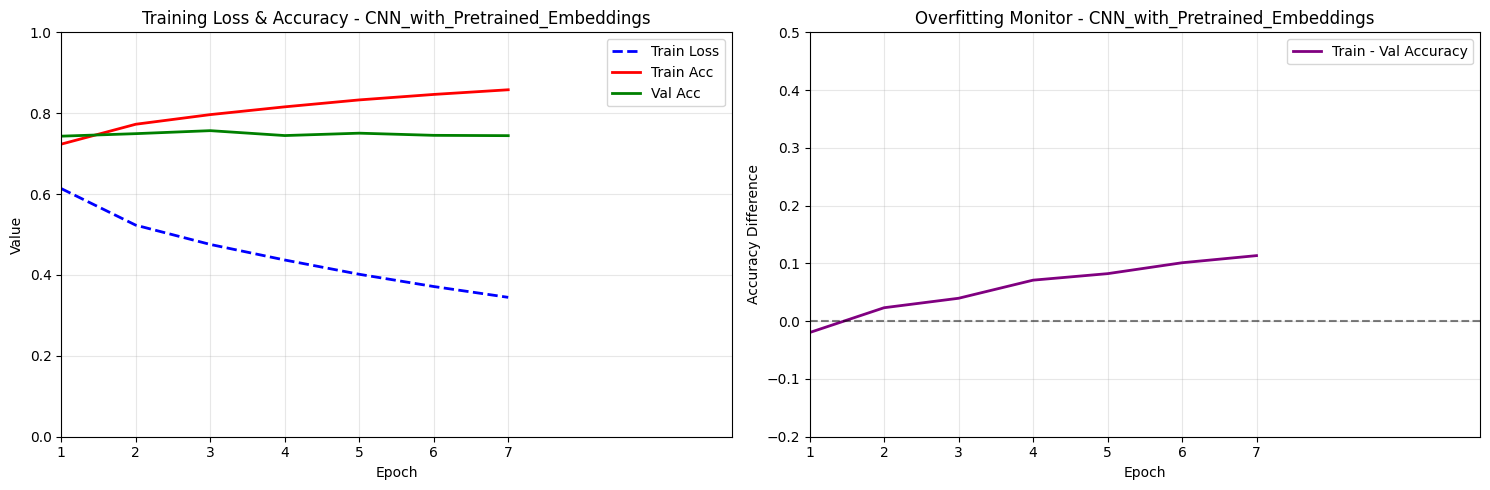


TRAINING SUMMARY
Model Name: CNN_with_Pretrained_Embeddings
Final Train Loss: 0.3446
Final Train Accuracy: 0.8580
Final Val Loss: 0.6323
Final Val Accuracy: 0.7445
Best Val Accuracy: 0.7569 (Epoch 3)
Final Overfitting Gap: 0.1135


In [12]:
# 绘制训练曲线
plot_training_curves("CNN_with_Pretrained_Embeddings", cnn_history)

# 打印训练摘要
print_training_summary("CNN_with_Pretrained_Embeddings", cnn_history)

Testing: 100%|██████████| 58491/58491 [00:57<00:00, 1021.56it/s]



TEST RESULTS
Model Name: CNN with Pretrained Embeddings
Test Accuracy: 0.7447
Test Precision (weighted): 0.7476
Test Recall (weighted): 0.7447
Test F1 Score (weighted): 0.7423

Detailed Test Classification Report:
              precision    recall  f1-score   support

    Negative     0.8304    0.6937    0.7559     18596
     Neutral     0.6435    0.6084    0.6254     14754
    Positive     0.7474    0.8624    0.8008     25141

    accuracy                         0.7447     58491
   macro avg     0.7405    0.7215    0.7274     58491
weighted avg     0.7476    0.7447    0.7423     58491



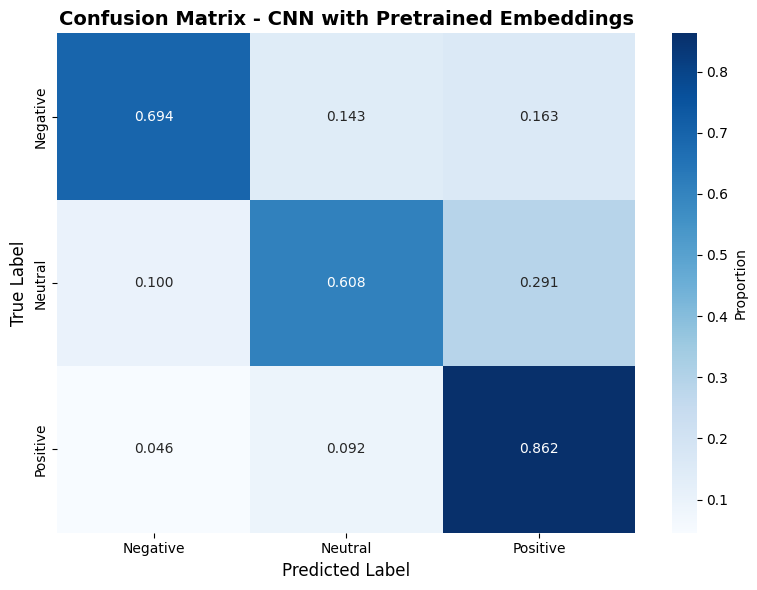


Per-Class Metrics:
------------------------------------------------------------
Negative: Precision=0.8304, Recall=0.6937, F1=0.7559, Support=18596
 Neutral: Precision=0.6435, Recall=0.6084, F1=0.6254, Support=14754
Positive: Precision=0.7474, Recall=0.8624, F1=0.8008, Support=25141


In [13]:
# CNN 测试过程 - 使用通用框架
cnn_test_results = test_model_comprehensive(
    model=cnn_pre_emb,
    model_name="CNN with Pretrained Embeddings",
    test_loader=test_data_loader_cnn,
    device=device
)

In [14]:
# 保存CNN训练结果
save_training_results(
    model=cnn_pre_emb,
    model_name="CNN with Pretrained Embeddings",
    set_epochs=num_epoch,
    actual_epochs=len(cnn_history['train_losses']),
    device=device,
    use_pretrained_embeddings=True,
    training_history=cnn_history,
    test_results=cnn_test_results,
    save_path="model_training_results.json"
)

✓ 训练结果已保存到 model_training_results.json
  - 模型: CNN with Pretrained Embeddings (CNN)
  - 实际训练轮数: 7
  - 测试准确率: 0.7447
  - 测试F1分数: 0.7423
  - 记录时间: 2025-11-17 09:54:56
  - 总记录数: 2


In [15]:
from MyModule import LSTM, collate_fn_lstm

train_data_loader_lstm = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_fn_lstm, shuffle=True)
val_data_loader_lstm = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn_lstm, shuffle=False)
test_data_loader_lstm = DataLoader(test_dataset, batch_size=1, collate_fn=collate_fn_lstm, shuffle=False)

# 加载模型
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lstm_pre_emb = LSTM(len(vocab), embedding_dim, hidden_dim, num_class, 
                    embedding_matrix.clone().detach(), freeze=False)
lstm_pre_emb.to(device)

LSTM(
  (embeddings): Embedding(35366, 200)
  (lstm): LSTM(200, 256, num_layers=2, batch_first=True, dropout=0.3)
  (dropout): Dropout(p=0.5, inplace=False)
  (output): Linear(in_features=256, out_features=3, bias=True)
)

In [16]:
# 训练过程
weights = class_weights(train_data)
criterion = nn.CrossEntropyLoss(weight=weights.to(device))
optimizer = torch.optim.Adam(lstm_pre_emb.parameters(), lr=0.001)

lstm_history = train_model_with_validation(
    model=lstm_pre_emb,
    train_loader=train_data_loader_lstm,
    val_loader=val_data_loader_lstm,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epoch,
    device=device
    )

Training Epoch 1: 100%|██████████| 8533/8533 [00:55<00:00, 154.52it/s]


Epoch 1/10
    Train Loss: 0.6014	Train Accuracy: 0.7309
    Valid Loss: 0.5447	Valid Accuracy: 0.7526
    Valid Precision: 0.7557	Valid Recall: 0.7526	Valid F1: 0.7489
    ✓ New best validation loss: 0.5447
--------------------------------------------------------------------------------


Training Epoch 2: 100%|██████████| 8533/8533 [00:54<00:00, 155.93it/s]


Epoch 2/10
    Train Loss: 0.4826	Train Accuracy: 0.7918
    Valid Loss: 0.5322	Valid Accuracy: 0.7677
    Valid Precision: 0.7679	Valid Recall: 0.7677	Valid F1: 0.7670
    ✓ New best validation loss: 0.5322
--------------------------------------------------------------------------------


Training Epoch 3: 100%|██████████| 8533/8533 [00:54<00:00, 156.14it/s]


Epoch 3/10
    Train Loss: 0.4055	Train Accuracy: 0.8280
    Valid Loss: 0.5642	Valid Accuracy: 0.7669
    Valid Precision: 0.7654	Valid Recall: 0.7669	Valid F1: 0.7645
    No improvement. Patience: 1/3
--------------------------------------------------------------------------------


Training Epoch 4: 100%|██████████| 8533/8533 [00:54<00:00, 155.29it/s]


Epoch 4/10
    Train Loss: 0.3327	Train Accuracy: 0.8605
    Valid Loss: 0.6145	Valid Accuracy: 0.7626
    Valid Precision: 0.7626	Valid Recall: 0.7626	Valid F1: 0.7617
    No improvement. Patience: 2/3
--------------------------------------------------------------------------------


Training Epoch 5: 100%|██████████| 8533/8533 [00:54<00:00, 155.72it/s]


Epoch 5/10
    Train Loss: 0.2674	Train Accuracy: 0.8887
    Valid Loss: 0.7123	Valid Accuracy: 0.7562
    Valid Precision: 0.7586	Valid Recall: 0.7562	Valid F1: 0.7559
    No improvement. Patience: 3/3
    Early stopping triggered! Best validation loss: 0.5322


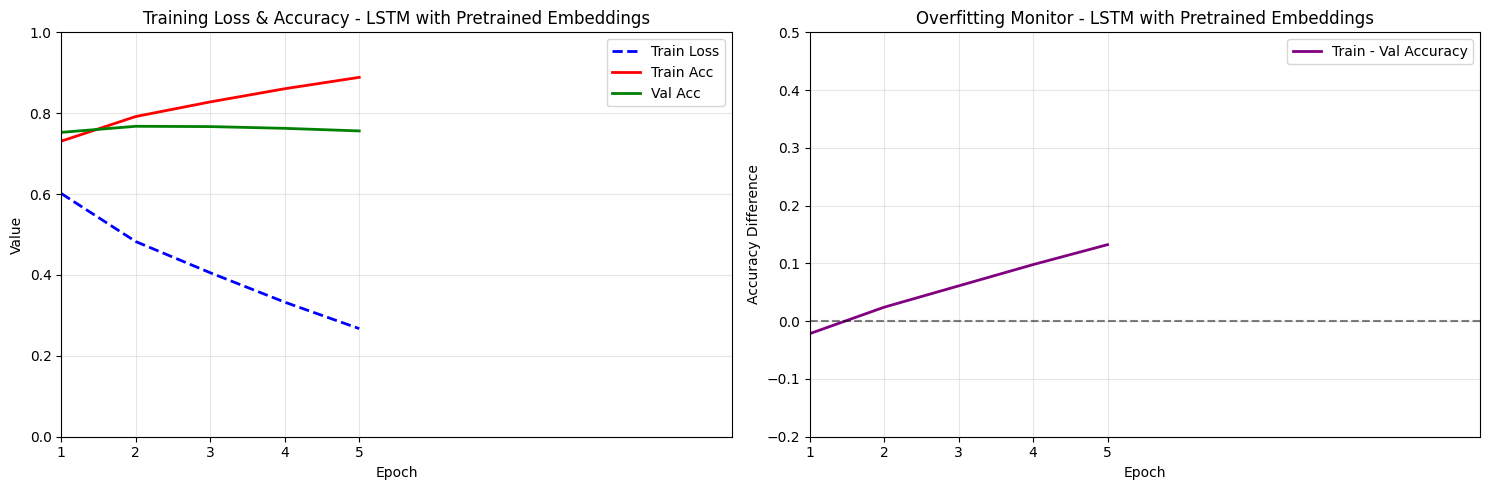


TRAINING SUMMARY
Model Name: LSTM with Pretrained Embeddings
Final Train Loss: 0.2674
Final Train Accuracy: 0.8887
Final Val Loss: 0.7123
Final Val Accuracy: 0.7562
Best Val Accuracy: 0.7677 (Epoch 2)
Final Overfitting Gap: 0.1325


In [17]:
# 绘制训练曲线
plot_training_curves("LSTM with Pretrained Embeddings", lstm_history)

# 打印训练摘要
print_training_summary("LSTM with Pretrained Embeddings", lstm_history)

Testing: 100%|██████████| 58491/58491 [01:14<00:00, 783.99it/s]



TEST RESULTS
Model Name: LSTM with Pretrained Embeddings
Test Accuracy: 0.7687
Test Precision (weighted): 0.7686
Test Recall (weighted): 0.7687
Test F1 Score (weighted): 0.7680

Detailed Test Classification Report:
              precision    recall  f1-score   support

    Negative     0.8210    0.7650    0.7920     18596
     Neutral     0.6690    0.6528    0.6608     14754
    Positive     0.7884    0.8394    0.8131     25141

    accuracy                         0.7687     58491
   macro avg     0.7595    0.7524    0.7553     58491
weighted avg     0.7686    0.7687    0.7680     58491



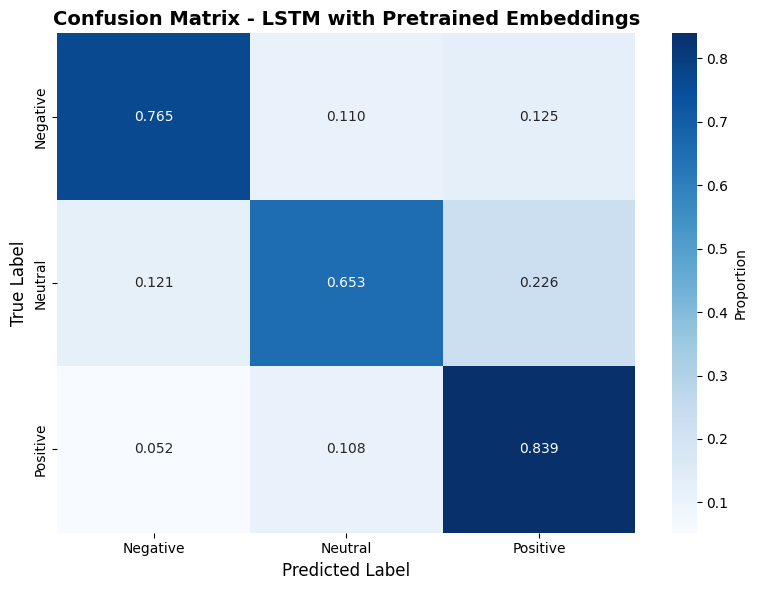


Per-Class Metrics:
------------------------------------------------------------
Negative: Precision=0.8210, Recall=0.7650, F1=0.7920, Support=18596
 Neutral: Precision=0.6690, Recall=0.6528, F1=0.6608, Support=14754
Positive: Precision=0.7884, Recall=0.8394, F1=0.8131, Support=25141


In [18]:
# LSTM 测试过程 - 使用通用框架
lstm_test_results = test_model_comprehensive(
    model=lstm_pre_emb,
    model_name="LSTM with Pretrained Embeddings", 
    test_loader=test_data_loader_lstm,
    device=device
)

In [ ]:
# 保存LSTM训练结果
save_training_results(
    model=lstm_pre_emb,
    model_name="LSTM with Pretrained Embeddings",
    set_epochs=num_epoch,
    actual_epochs=len(lstm_history['train_losses']),
    device=device,
    use_pretrained_embeddings=True,
    training_history=lstm_history,
    test_results=lstm_test_results,
    save_path="model_training_results.json"
)

✓ 训练结果已保存到 model_training_results.json
  - 模型: LSTM with Pretrained Embeddings (LSTM)
  - 实际训练轮数: 5
  - 测试准确率: 0.7687
  - 测试F1分数: 0.7680
  - 记录时间: 2025-11-17 10:01:11
  - 总记录数: 3


In [4]:
from MyModule import Transformer, collate_fn_trans

train_data_loader_trans = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_fn_trans, shuffle=True)
val_data_loader_trans = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn_trans, shuffle=False)
test_data_loader_trans = DataLoader(test_dataset, batch_size=1, collate_fn=collate_fn_trans, shuffle=False)

# 加载模型
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
transformer_pre_emb = Transformer(len(vocab), embedding_dim, num_class, 
                                  pretrained_embedding_matrix=embedding_matrix.clone().detach(), 
                                  freeze=False)
transformer_pre_emb.to(device)

e:\anaconda3\envs\nlpllma\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Transformer(
  (embeddings): Embedding(35366, 200)
  (position_embedding): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=200, out_features=200, bias=True)
        )
        (linear1): Linear(in_features=200, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=200, bias=True)
        (norm1): LayerNorm((200,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((200,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (output): Linear(in_features=200, out_features=3, bias=True)
)

In [5]:

# 训练过程
weights = class_weights(train_data)
criterion = nn.CrossEntropyLoss(weight=weights.to(device))
optimizer = torch.optim.Adam(transformer_pre_emb.parameters(), lr=0.001)

transformer_history = train_model_with_validation(
    model=transformer_pre_emb,
    train_loader=train_data_loader_trans,
    val_loader=val_data_loader_trans,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epoch,
    device=device
)

Training Epoch 1: 100%|██████████| 8533/8533 [01:02<00:00, 137.19it/s]


Epoch 1/10
    Train Loss: 0.7477	Train Accuracy: 0.6571
    Valid Loss: 0.7031	Valid Accuracy: 0.6894
    Valid Precision: 0.6875	Valid Recall: 0.6894	Valid F1: 0.6812
    ✓ New best validation loss: 0.7031
--------------------------------------------------------------------------------


Training Epoch 2: 100%|██████████| 8533/8533 [01:01<00:00, 138.83it/s]


Epoch 2/10
    Train Loss: 0.6939	Train Accuracy: 0.6911
    Valid Loss: 0.6939	Valid Accuracy: 0.6965
    Valid Precision: 0.6921	Valid Recall: 0.6965	Valid F1: 0.6902
    ✓ New best validation loss: 0.6939
--------------------------------------------------------------------------------


Training Epoch 3: 100%|██████████| 8533/8533 [01:01<00:00, 139.06it/s]


Epoch 3/10
    Train Loss: 0.6908	Train Accuracy: 0.6946
    Valid Loss: 0.6894	Valid Accuracy: 0.6965
    Valid Precision: 0.6930	Valid Recall: 0.6965	Valid F1: 0.6935
    ✓ New best validation loss: 0.6894
--------------------------------------------------------------------------------


Training Epoch 4: 100%|██████████| 8533/8533 [01:01<00:00, 137.90it/s]


Epoch 4/10
    Train Loss: 0.6808	Train Accuracy: 0.6953
    Valid Loss: 0.6943	Valid Accuracy: 0.6990
    Valid Precision: 0.6955	Valid Recall: 0.6990	Valid F1: 0.6958
    No improvement. Patience: 1/3
--------------------------------------------------------------------------------


Training Epoch 5: 100%|██████████| 8533/8533 [01:01<00:00, 138.51it/s]


Epoch 5/10
    Train Loss: 0.6578	Train Accuracy: 0.7078
    Valid Loss: 0.6894	Valid Accuracy: 0.6812
    Valid Precision: 0.6916	Valid Recall: 0.6812	Valid F1: 0.6741
    No improvement. Patience: 2/3
--------------------------------------------------------------------------------


Training Epoch 6: 100%|██████████| 8533/8533 [01:01<00:00, 138.54it/s]


Epoch 6/10
    Train Loss: 0.6401	Train Accuracy: 0.7173
    Valid Loss: 0.6837	Valid Accuracy: 0.6911
    Valid Precision: 0.6960	Valid Recall: 0.6911	Valid F1: 0.6872
    ✓ New best validation loss: 0.6837
--------------------------------------------------------------------------------


Training Epoch 7: 100%|██████████| 8533/8533 [01:01<00:00, 137.96it/s]


Epoch 7/10
    Train Loss: 0.6230	Train Accuracy: 0.7263
    Valid Loss: 0.6808	Valid Accuracy: 0.6984
    Valid Precision: 0.6997	Valid Recall: 0.6984	Valid F1: 0.6937
    ✓ New best validation loss: 0.6808
--------------------------------------------------------------------------------


Training Epoch 8: 100%|██████████| 8533/8533 [01:01<00:00, 138.53it/s]


Epoch 8/10
    Train Loss: 0.6114	Train Accuracy: 0.7318
    Valid Loss: 0.6874	Valid Accuracy: 0.6911
    Valid Precision: 0.6953	Valid Recall: 0.6911	Valid F1: 0.6830
    No improvement. Patience: 1/3
--------------------------------------------------------------------------------


Training Epoch 9: 100%|██████████| 8533/8533 [01:01<00:00, 138.26it/s]


Epoch 9/10
    Train Loss: 0.6100	Train Accuracy: 0.7335
    Valid Loss: 0.6853	Valid Accuracy: 0.6947
    Valid Precision: 0.6965	Valid Recall: 0.6947	Valid F1: 0.6903
    No improvement. Patience: 2/3
--------------------------------------------------------------------------------


Training Epoch 10: 100%|██████████| 8533/8533 [01:01<00:00, 137.74it/s]


Epoch 10/10
    Train Loss: 0.6029	Train Accuracy: 0.7366
    Valid Loss: 0.6877	Valid Accuracy: 0.7039
    Valid Precision: 0.7020	Valid Recall: 0.7039	Valid F1: 0.7016
    No improvement. Patience: 3/3
    Early stopping triggered! Best validation loss: 0.6808


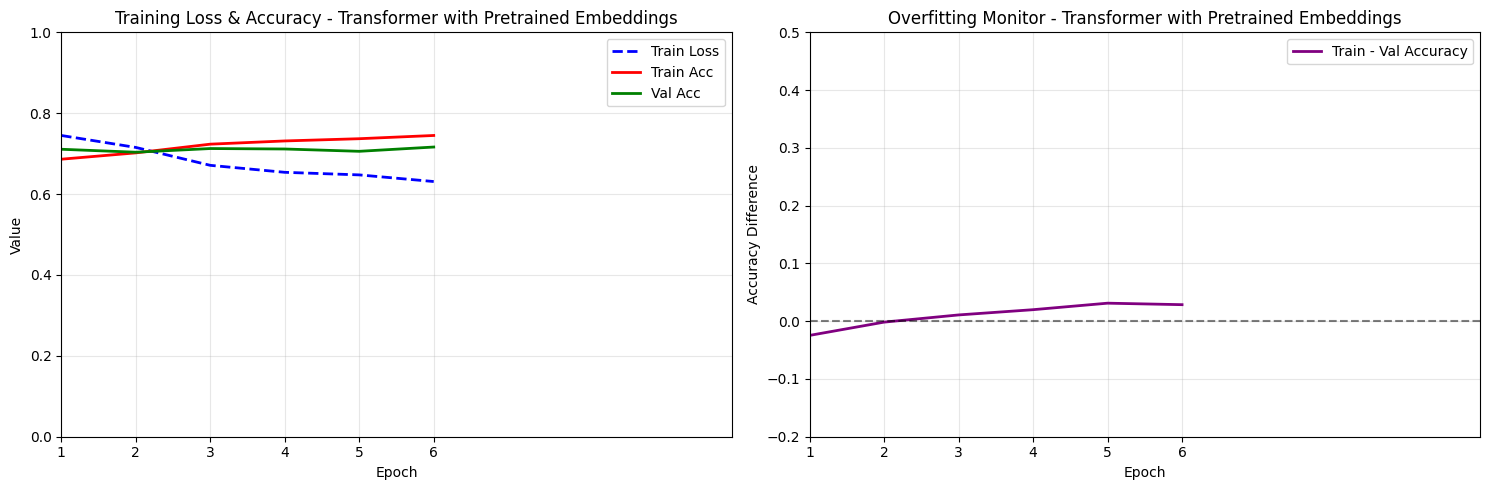


TRAINING SUMMARY
Model Name: Transformer with Pretrained Embeddings with Pretrained Embeddings
Final Train Loss: 0.6310
Final Train Accuracy: 0.7449
Final Val Loss: 0.6994
Final Val Accuracy: 0.7164
Best Val Accuracy: 0.7164 (Epoch 6)
Final Overfitting Gap: 0.0286


In [ ]:
# 绘制训练曲线
plot_training_curves("Transformer with Pretrained Embeddings", transformer_history)

# 打印训练摘要
print_training_summary("Transformer with Pretrained Embeddings with Pretrained Embeddings", transformer_history)

Testing: 100%|██████████| 53687/53687 [01:50<00:00, 485.99it/s]



TEST RESULTS
Model Name: Transformer with Pretrained Embeddings
Test Accuracy: 0.7107
Test Precision (weighted): 0.7027
Test Recall (weighted): 0.7107
Test F1 Score (weighted): 0.7050

Detailed Test Classification Report:
              precision    recall  f1-score   support

    Negative     0.7181    0.7680    0.7422     18614
     Neutral     0.5342    0.4187    0.4694      9924
    Positive     0.7578    0.7835    0.7705     25149

    accuracy                         0.7107     53687
   macro avg     0.6700    0.6567    0.6607     53687
weighted avg     0.7027    0.7107    0.7050     53687



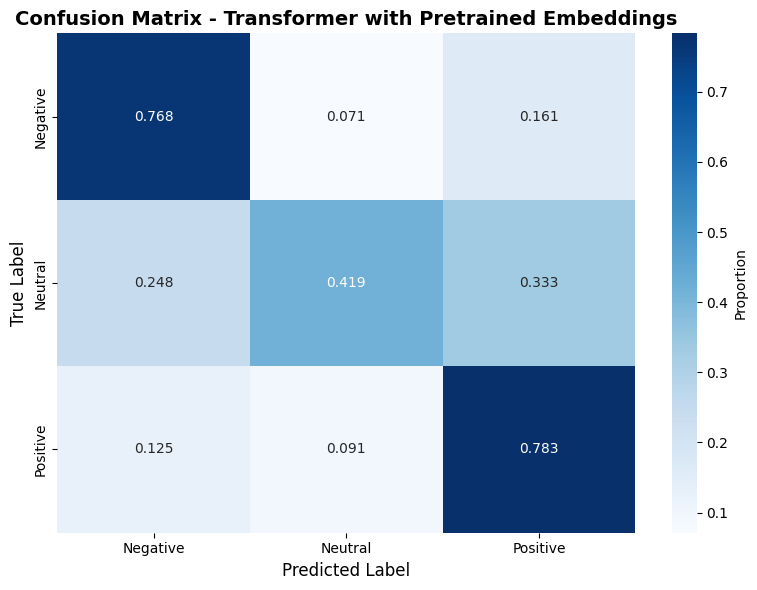


Per-Class Metrics:
------------------------------------------------------------
Negative: Precision=0.7181, Recall=0.7680, F1=0.7422, Support=18614
 Neutral: Precision=0.5342, Recall=0.4187, F1=0.4694, Support=9924
Positive: Precision=0.7578, Recall=0.7835, F1=0.7705, Support=25149


In [ ]:
# Transformer 测试过程 - 使用通用框架
transformer_test_results = test_model_comprehensive(
    model=transformer_pre_emb,
    model_name="Transformer with Pretrained Embeddings",
    test_loader=test_data_loader_trans,
    device=device
)

In [ ]:
# 保存MLP训练结果
save_training_results(
    model=transformer_pre_emb,
    model_name="Transformer with Pretrained Embeddings",
    set_epochs=num_epoch,
    actual_epochs=len(transformer_history['train_losses']),
    device=device,
    use_pretrained_embeddings=True,
    training_history=transformer_history,
    test_results=transformer_test_results,
    save_path="model_training_results.json"
)

✓ 训练结果已保存到 model_training_results.json
  - 模型: Transformer with Pretrained Embeddings (Transformer)
  - 实际训练轮数: 6
  - 测试准确率: 0.7107
  - 测试F1分数: 0.7050
  - 记录时间: 2025-11-15 14:20:02
  - 总记录数: 10
